In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, clear_output

# Perceptron Learning Algorithm

In [ ]:
class PLA_experiment():
    """
    Perform PLA exercise from the course Learning from Data
    from Yaser Abu-Mostafa. This code covers from 7th to 10th
    exercise from the first homework.
    """
    def __init__(self):
        self.x = np.linspace(-1.0, 1.0, num=10)
        self.seed = 1
        self.number_of_points = 10
        self.points = []
        self.list_steps = []
        self.list_e_out = []
        self.w_history = []
        self.g_history = []
        self.draw = None

    def initialize_points(self):
        """
        Function utilized do initialize N uniformly random points
        """
        np.random.seed(self.seed)
        N = self.number_of_points
        self.points = np.random.uniform(low=-1.0, high=1.0, size=(2,N))

    def vectorized_line(self, x):
        """
        Create a parametrized line between two points
        this line will be f that classify to +1 and -1
        """
        np.random.seed(self.seed)
        # 2 points from -1 to +1 
        v0 = np.random.uniform(low=-1.0, high=1.0, size=(2,1))
        v1 = np.random.uniform(low=-1.0, high=1.0, size=(2,1))
        # Vector parallel to line
        v_parallel = (v0-v1)
        # Initial point
        init_p = v1
        v_f = init_p + v_parallel * x
        # position 0 has x and position 1 has y
        return v_f

    def classify(self):
        """
        Classify current points with current function
        """
        vectorized_line = self.vectorized_line
        points = self.points
        classification = (points[1,:] >= vectorized_line(points[0,:])[1,:]).astype(int)
        classification[classification==0] = -1
        return classification

    def create_X(self):
        """
        Add one dimension to x to create x0
        used to calculate the bias
        """
        num_x = self.points.shape[1]
        # To add x0 on the dimension
        dim_x = self.points.shape[0] + 1 
        # Creating N x's with x0=1
        X = np.ones((dim_x, num_x))
        # setting x1 to xn to points uniformly generated
        X[1:,:] = np.copy(self.points)
        return X

    def pla_algorithm(self, w_initial=None):
        """
        Perform PLA algorithm until convergence given points,
        and function f. Count how many steps it takes to converge
        and save each w and g for plotting purposes.
        """
        np.random.seed(self.seed)
        X = self.create_X()
        Y = self.classify()
        if w_initial is not None:
            W = w_initial
        else:
            W = np.zeros(X.shape[0])
        steps = 0
        w_history = []
        g_history = []
        while True:
            # For animation purposes
            w_history.append(W)
            # find new hypothesis g
            g = np.sign(W.dot(X))
            # For animation purposes
            g_history.append(g)
            # See which y are missclassified
            y_hat = (Y != g).astype(int)
            # List of index that are missclassified
            misclassified_set = np.where(y_hat==1)[0]
            # If there is no missclassification stop
            if len(misclassified_set) == 0:
                break;
            # Choose randomly from missclassification set
            index = np.random.choice(misclassified_set)
            W = W + Y[index]*X[:,index]
            steps += 1

        self.list_steps.append(steps)
        self.w_history = w_history
        self.g_history = g_history

    def noise_pocket_pla_algorithm(self, i_steps, w_initial):
        """
        Perform a noise pocket PLA algorithm until i steps.
        Count how many steps it takes to converge
        and save each w and g for calculating E_out.
        """
        np.random.seed(self.seed)
        X = self.create_X()
        Y = self.classify()
        y_size = len(Y)
        # Number of samples, 10% of Y size
        sample_size = math.ceil(y_size*0.1)
        y_index = range(y_size)
        # Choose 10% of Y withouht replacement
        changed_index = np.random.choice(y_index, sample_size, replace=False)
        # Change chosen Y to its oposit label
        for idx in changed_index:
            Y[idx] = Y[idx]*(-1)
        if w_initial is not None:
            W = w_initial
        else:
            W = np.zeros(X.shape[0])
        steps = 0
        w_history = []
        g_history = []
  
        for i in range(i_steps):
            W_new = W.copy()
            # For animation purposes
            w_history.append(W)
            # find new hypothesis g
            g = np.sign(W.dot(X))
            # For animation purposes
            g_history.append(g)
            # See which y are missclassified
            y_hat = (Y != g).astype(int)
            # List of index that are missclassified
            misclassified_set = np.where(y_hat==1)[0]
            # Count misclassified set
            last_size_misclassified_set = len(misclassified_set)
            # Choose randomly from missclassification set
            index = np.random.choice(misclassified_set)
            # Update vector W_new
            W_new = W_new + Y[index]*X[:,index]
            # Check if W_new is better then last W
            g_hat = np.sign(W_new.dot(X))
            # For animation purposes
            # See which y are missclassified
            y_hat_new = (Y != g_hat).astype(int)
            # List of index that are missclassified
            misclassified_set_new = np.where(y_hat_new==1)[0]
            # If the new missclassification set is less than the last one
            # change vector W
            if last_size_misclassified_set > len(misclassified_set_new):
                W = W_new
            steps += 1

        self.list_steps.append(steps)
        self.w_history = w_history
        self.g_history = g_history

    def calculate_e_out(self, noise):
        """
        Calculate E_out using 1000 uniformly generated points
        """
        self.number_of_points = 1000
        self.initialize_points()
        # y using f
        Y = self.classify()
        # get w that converged
        w_final = self.w_history[-1]
        X = self.create_X()
        g = np.sign(w_final.dot(X))
        # y_hat using g
        y_hat = (Y != g).astype(int)
        # List of index that are missclassified
        misclassified_set = np.where(y_hat==1)[0]
        # E_out = Missclassified points / Total points
        probability = len(misclassified_set)/self.number_of_points
        self.list_e_out.append(probability)

    def run_experiment(self, number_of_points, w_initial=None, noise=False, i_steps=0, plot_error=False):
        """
        Run experiment with 1000 iterations
        After these interations take the avg.
        from each statistics.
        It changes random seed for each iteration, 
        we fixed how it changes the seed
        to be able to compare the results.
        OBS: plot error is not used, it's just a plus. 
        To see E_out with f and g look for plot_f_g()
        """
        number_of_runs = 1000
        for i in range(number_of_runs):
            self.seed += i      
            self.initialize_points()
            if not noise:
                self.pla_algorithm(w_initial)
            else:
                self.noise_pocket_pla_algorithm(i_steps, w_initial)
            self.calculate_e_out(noise)
            self.number_of_points = number_of_points
            average_steps = np.sum(self.list_steps)/number_of_runs
            average_e_out = np.sum(self.list_e_out)/number_of_runs
        self.list_steps = []
        if plot_error:
            self.plot_error()
        self.list_e_out = []
        print(f"Average steps:{average_steps} and average E_out:{average_e_out},  using {self.number_of_points} points.")

    def create_labels_colors(self, classification):
        """
        Define colors and labels based on classification
        each index is asigned with a different color or label
        """
        colors = np.copy(classification).astype(str)
        labels = np.copy(classification).astype(str)
        colors[colors=='1'] = 'g'
        colors[colors=='-1'] = 'r'
        labels[labels=='1'] = '+1'
        labels[labels=='-1'] = '-1'
        return colors, labels

    def plot_error(self):
        """
        Plot error out of sample using moving
        average to see how it goes throw the runs.
        """
        error = pd.Series(self.list_e_out)
        long_rolling_error = error.rolling(window=100).mean()
        fig, ax = plt.subplots(figsize=(16,9))
        ax.set_title("E_out with moving average and window equal to 100")
        ax.plot(long_rolling_error)

    def plot_graph(self):
        """
        Plot graph given points and function with current seed,
        using classification to see which class the point belongs
        """
        x = self.x
        vectorized_line = self.vectorized_line
        points = self.points
        # Classify points within the generated function
        classification = self.classify()
        colors, labels = self.create_labels_colors(classification)
        plt.plot(x, vectorized_line(x)[1,:])
        for i, (c,l) in enumerate(zip(colors, labels)):
            plt.scatter(self.points[0,i], self.points[1,i] , c=c, label=l)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys()) 

    def update_graph(self, i):
        """
        Update plot iterating over weights history
        and classification history
        """
        ax = self.drawable[0]
        line = self.drawable[1]
        w = self.w_history[i]
        g = self.g_history[i]
        x = self.x
        classification = g.copy().astype(int)
        colors, labels = self.create_labels_colors(classification)
        ax.scatter(self.points[0,:], self.points[1,:] , c=colors)

        epsilon = 1e-18
        w += epsilon
        slope = -(w[0]/w[2])/(w[0]/w[1])
        bias = -(w[0]/w[2])
        y = (slope*x)+bias
        line.set_data(x, y)
        return (line),

    def plot_animated_graph(self):
        """
        Create an animated graph with the last convergence weights and classifications
        to see how the algorithm updates its weights throw iterations.
        """
        fig, ax = plt.subplots()
        ax.set_xlim(( -1, 1))
        ax.set_ylim(( -1, 1))
        classification = self.classify()
        colors, labels = self.create_labels_colors(classification)
        for i, (c,l) in enumerate(zip(colors, labels)):
            ax.scatter(self.points[0,i], self.points[1,i] , c=c, label=l)

        line, = ax.plot([], [], lw=2)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        self.drawable = [ax, line]
        anim = animation.FuncAnimation(fig, self.update_graph, frames=len(self.w_history), interval=500, 
                                    blit=True)
        return anim

    def plot_f_g(self):
        """
        Plot 1000 points with Target function f and 
        Hypothesis g, to see how good g is performing.
        """
        self.number_of_points = 1000
        self.initialize_points()
        # y using f
        Y = self.classify()
        # get w that converged
        w = self.w_history[-1]
        X = self.create_X()
        g = np.sign(w.dot(X))

        epsilon = 1e-18
        w += epsilon
        slope = -(w[0]/w[2])/(w[0]/w[1])
        bias = -(w[0]/w[2])

        x = self.x
        y = (slope*x)+bias
        vectorized_line = self.vectorized_line
        points = self.points
        # Classify points within the generated function
        classification = Y
        colors, labels = self.create_labels_colors(classification)
        plt.plot(x, vectorized_line(x)[1,:], color= 'b', label='Target F')
        plt.plot(x, y, color='k', label='Hypothesis G')
        for i, (c,l) in enumerate(zip(colors, labels)):
            plt.scatter(self.points[0,i], self.points[1,i] , c=c, label=l)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())


In [ ]:
p = PLA_experiment()

In [ ]:
p.initialize_points()

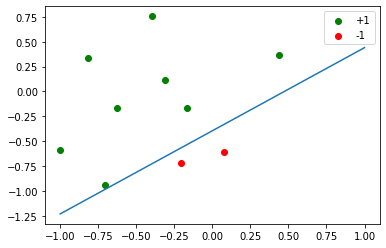

In [ ]:
p.plot_graph()

In [ ]:
p.pla_algorithm()

In [ ]:
anim = p.plot_animated_graph()

In [ ]:
# Animation of the iterations updating W
HTML(anim.to_jshtml())

In [ ]:
# Resolvendo o primeiro e segundo exercício da lista de Inteligência Computacional
p = PLA_experiment()
p.run_experiment(number_of_points=10)

Average steps:9.554 and average E_out:0.111305,  using 10 points.


- Answer 7th question : [b] $\approx 15 $ avg. steps
- Answer 8th question : [c] $\approx 0.1 $ avg. $E_{out}$

In [ ]:
# Resolvendo o terceiro e quarto exercício da lista de Inteligência Computacional
p.run_experiment(number_of_points=100)

Average steps:116.876 and average E_out:0.013302000000000001,  using 100 points.


- Answer 9th question : [b] $\approx 100 $ avg. steps
- Answer 10th question : [b] $\approx 0.01 $ avg. $E_{out}$

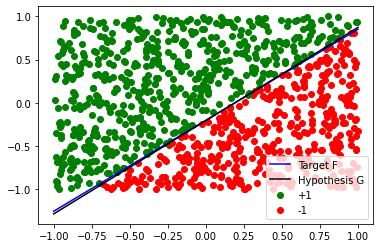

In [ ]:
# Resolvendo o quinto exercício da lista de Inteligência Computacional
# E_out Graph for the last run of the experiment using PLA
p.plot_f_g()

# Linear Regression

In [ ]:
class Linear_Regression_experiment():
    """
    Perform Linear Regression exercise from the course Learning 
    from Data from Yaser Abu-Mostafa. This code covers from 5th 
    to 10th exercise from the second homework.
    """
    def __init__(self):
        self.x = np.linspace(-1.0, 1.0, num=10)
        self.seed = 123
        self.number_of_points = 10
        self.points = []
        self.list_e_in = []
        self.list_e_out = []
        self.w_history = []
        self.g_history = []
        self.draw = None

    def initialize_points(self):
        """
        Function utilized do initialize N uniformly random points
        """
        np.random.seed(self.seed)
        N = self.number_of_points
        self.points = np.random.uniform(low=-1.0, high=1.0, size=(N,2))

    def vectorized_line(self, x):
        """
        Create a parametrized line between two points
        this line will be f that classify to +1 and -1
        """
        np.random.seed(self.seed)
        # 2 points from -1 to +1 
        v0 = np.random.uniform(low=-1.0, high=1.0, size=(2,1))
        v1 = np.random.uniform(low=-1.0, high=1.0, size=(2,1))
        # Vector parallel to line
        v_parallel = (v0-v1)
        # Initial point
        init_p = v1
        v_f = init_p + v_parallel * x
        # position 0 has x and position 1 has y
        return v_f

    def classify(self):
        """
        Classify current points with current function
        """
        vectorized_line = self.vectorized_line
        points = self.points
        classification = (points[:,1] >= vectorized_line(points[:,0])[1,:]).astype(int)
        classification[classification==0] = -1
        return classification

    def create_X(self):
        """
        Add one dimension to x to create x0
        used to calculate the bias
        """
        num_x = self.points.shape[0]
        # To add x0 on the dimension
        dim_x = self.points.shape[1] + 1 
        # Creating N x's with x0=1
        X = np.ones((num_x,dim_x))
        # setting x1 to xn to points uniformly generated
        X[:,1:] = np.copy(self.points)
        return X

    def create_non_linear_X(self):
        """
        Create a non linear X as described on
        9th exercise, with X being:
        X = (1, x_1, x_2, x_1*x_2, x_1^2, x_2^2)
        """
        points = self.points
        num_x = points.shape[0]
        # To add 4 dimensions as transformation sugests
        dim_x = points.shape[1] + 4
        # Creating X with 6 dimensions (0 to 5)
        # dimension 0 will be all 1 due to bias
        X = np.ones((num_x,dim_x))
        # setting dimensions 1 and 2 to points x_1 and x_2
        X[:,1:3] = np.copy(points)
        # setting third dimension to x_1*x_2
        X[:,3] = np.copy(points[:,0]*points[:,1])
        # setting the last dimensions to x_1**2 and x_2**2
        X[:,4:] = np.copy(points**2)
        return X

    def target_function(self):
        """
        Implements 8th exercise target function
        f(x_1, x_2) = x_1^2 + x_2^2 - 0.6
        """
        points = self.points
        f = points[:,0]**2 + points[:,1]**2 - 0.6
        return np.sign(f)

    def linear_regression_algorithm(self, noise=False, random_f=True, linear=True):
        """
        Perform Linear Regression algorithm given points 
        and function f. Calculate E_in after convergence.
        """
        np.random.seed(self.seed)
        # Check if we are going to use a linear or a non-linear X
        if linear:
            X = self.create_X()
        else:
            X = self.create_non_linear_X()
        # Check if we are going to use a random function f
        if random_f:
            Y = self.classify()
        else:
            Y = self.target_function()    
        # Check if we are going to add noise to Y
        if noise:
            y_size = len(Y)
            # Number of samples, 10% of Y size
            sample_size = math.ceil(y_size*0.1)
            y_index = range(y_size)
            # Choose 10% of Y without replacement
            changed_index = np.random.choice(y_index, sample_size, replace=False)
            # Change chosen Y to its oposit label
            for idx in changed_index:
                Y[idx] = Y[idx]*(-1)

        W = np.zeros(X.shape[1])
        steps = 0
        w_history = []
        g_history = []
        # Create pseudo inverse to find w
        pseudo_inverse = np.linalg.inv(X.T.dot(X)).dot(X.T)
        # Find w using pseudo and Y
        w = pseudo_inverse.dot(Y)
        # Find g using Xw
        g = np.sign(X.dot(w))

        miss_y = (Y != g).astype(int)
        # List of points that are missclassified
        misclassified_set = np.where(miss_y==1)[0]
        # E_in = Missclassified points / Total points
        e_in = len(misclassified_set)/self.number_of_points

        g_history.append(g)
        w_history.append(w)
        self.g_history = g_history
        self.w_history = w_history
        self.list_e_in.append(e_in)

    def calculate_e_out(self, random_f=True, linear=True, noise=False):
        """
        Calculate E_out using 1000 uniformly generated points
        """
        self.number_of_points = 1000
        self.initialize_points()

        # Check if we are going to use a random function f
        if random_f:
            Y = self.classify()
        else:
            Y = self.target_function()
        # get w that converged
        w_final = self.w_history[-1]
        # Check if we are going to use a linear or a non-linear X
        if linear:
            X = self.create_X()
        else:
            X = self.create_non_linear_X()

        if noise:
            y_size = len(Y)
            # Number of samples, 10% of Y size
            sample_size = math.ceil(y_size*0.1)
            y_index = range(y_size)
            # Choose 10% of Y without replacement
            changed_index = np.random.choice(y_index, sample_size, replace=False)
            # Change chosen Y to its oposit label
            for idx in changed_index:
                Y[idx] = Y[idx]*(-1)

        g = np.sign(X.dot(w_final))
        # y_hat using g
        y_hat = (Y != g).astype(int)
        # List of index that are missclassified
        misclassified_set = np.where(y_hat==1)[0]
        # E_out = Missclassified points / Total points
        probability = len(misclassified_set)/self.number_of_points
        self.list_e_out.append(probability)

    def check_function(self):
        """
        Check which function w belongs to
        This method is used only for the 9th exercise
        from the second homework.
        """
        W = self.w_history[-1]
        X = self.create_non_linear_X()
        x1 = self.points[:,0]
        x2 = self.points[:,1]
        g_founded = np.sign(X.dot(W))
        g_a = np.sign(-1 - 0.05*x1 + 0.08*x2 + 0.13*x1*x2 + 1.5*x1**2 + 1.5*x2**2)
        g_b = np.sign(-1 - 0.05*x1 + 0.08*x2 + 0.13*x1*x2 + 1.5*x1**2 + 15*x2**2)
        g_c = np.sign(-1 - 0.05*x1 + 0.08*x2 + 0.13*x1*x2 + 15*x1**2 + 1.5*x2**2)
        g_d = np.sign(-1 - 1.5*x1 + 0.08*x2 + 0.13*x1*x2 + 0.05*x1**2 + 0.05*x2**2)
        g_e = np.sign(-1 - 0.05*x1 + 0.08*x2 + 1.5*x1*x2 + 0.15*x1**2 + 0.15*x2**2)

        functions = {'G_a':g_a, 'G_b':g_b, 'G_c':g_c, 'G_d':g_d, 'G_e':g_e, }
        e_in = {}
        for f in functions:
            g = functions[f]
            miss_y = (g_founded != g).astype(int)
            # List of points that are missclassified
            misclassified_set = np.where(miss_y==1)[0]
            # E_in = Missclassified points / Total points
            e_in_f = len(misclassified_set)/self.number_of_points
            e_in[f] = e_in_f 

        # Function which has minimum e_in
        f_min_e_in = min(e_in, key=e_in.get)
        print(f"The function which is similar to our founded g is {f_min_e_in}")


    def run_experiment(self, number_of_points, noise=False , random_f=True, linear=True):
        """
        Run experiment over 1000 runs, use different parameters
        to handle different exercises. It changes random seed
        for each iteration, we fixed how it changes the seed
        to be able to compare the results.
        """
        number_of_runs = 1000
        for i in range(number_of_runs):
            self.seed += i
            self.initialize_points()
            self.linear_regression_algorithm(noise=noise, random_f=random_f, linear=linear)
            self.calculate_e_out(random_f=random_f, linear=linear, noise=noise)
            self.number_of_points = number_of_points
            average_e_in = np.sum(self.list_e_in)/number_of_runs
            average_e_out = np.sum(self.list_e_out)/number_of_runs
        self.list_e_in = []
        self.list_e_out = []
        print(f"Average E_in:{average_e_in} and average E_out:{average_e_out},  using {self.number_of_points} points.")

    def create_labels_colors(self, classification):
        """
        Define colors and labels based on classification
        each index is asigned with a different color or label
        """
        colors = np.copy(classification).astype(str)
        labels = np.copy(classification).astype(str)
        colors[colors=='1'] = 'g'
        colors[colors=='-1'] = 'r'
        labels[labels=='1'] = '+1'
        labels[labels=='-1'] = '-1'
        return colors, labels

    def get_slope_bias(self, w):
        """
        Get slope and bias from line
        given current w with 3 dimensions
        """
        epsilon = 1e-18
        w += epsilon
        slope = -(w[0]/w[2])/(w[0]/w[1])
        bias = -(w[0]/w[2])
        return slope, bias

    def set_labels(self):
        """
        Small function to set aggregate labels of each point
        """
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

    def plot_graph(self):
        """
        Plot graph given points and function with current seed,
        using classification to see which class the point belongs
        """
        x = self.x
        vectorized_line = self.vectorized_line
        points = self.points
        # Classify points within the generated function
        classification = self.classify()
        colors, labels = self.create_labels_colors(classification)
        plt.plot(x, vectorized_line(x)[1,:])
        for i, (c,l) in enumerate(zip(colors, labels)):
            plt.scatter(self.points[i,0], self.points[i,1] , c=c, label=l)
        self.set_labels()

    def plot_f_g(self):
        """
        Plot 1000 points with Target function f and 
        Hypothesis g, to see how good g is performing.
        """
        self.number_of_points = 1000
        self.initialize_points()
        # y using f
        Y = self.classify()
        # get w that converged
        w = self.w_history[-1]
        X = self.create_X()
        g = np.sign(X.dot(w))

        slope, bias = self.get_slope_bias(w)
        x = self.x
        y = (slope*x)+bias
        vectorized_line = self.vectorized_line
        points = self.points
        # Classify points within the generated function
        classification = Y
        colors, labels = self.create_labels_colors(classification)
        plt.plot(x, vectorized_line(x)[1,:], color= 'b', label='Target F')
        plt.plot(x, y, color='k', label='Hypothesis G')
        for i, (c,l) in enumerate(zip(colors, labels)):
            plt.scatter(self.points[i,0], self.points[i,1] , c=c, label=l)
        self.set_labels()


In [ ]:
lr = Linear_Regression_experiment()

In [ ]:
# Resolvendo o sexto e sétimo exercício da lista de Inteligência Computacional
lr.run_experiment(number_of_points=100)

Average E_in:0.039400000000000004 and average E_out:0.04770300000000001,  using 100 points.


- Answer 5th question : [c] $\approx 0.01 $ avg. $E_{in}$
- Answer 6th question : [c] $\approx 0.01 $ avg. $E_{out}$

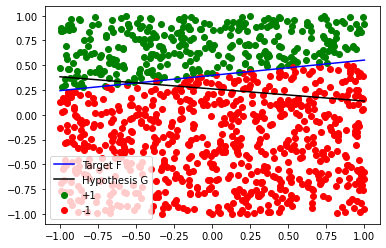

In [ ]:
# E_out plot of last run of linear regression
lr.plot_f_g()

In [ ]:
# Resolvendo o oitavo exercício da lista de Inteligência Computacional
lr = Linear_Regression_experiment()
lr.number_of_points = 10
lr.initialize_points()
lr.linear_regression_algorithm()
w = lr.w_history[-1]
p = PLA_experiment()
p.run_experiment(number_of_points=10, w_initial=w)

Average steps:6.669 and average E_out:0.10145699999999999,  using 10 points.


- Answer 7th question : [a] $\approx 1 $ avg. step

In [ ]:
# Resolvendo o nono exercício da lista de Inteligência Computacional
# OBS: N2 é sempre 1000
# questão a)
p = PLA_experiment()
p.run_experiment(number_of_points=100, noise=True, i_steps=10)

Average steps:10.0 and average E_out:0.183418,  using 100 points.


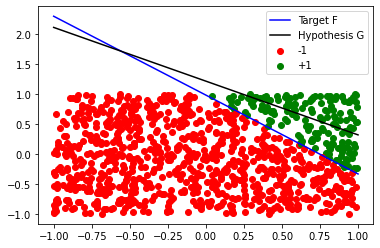

In [ ]:
# Gráfico ultima rodada de E_out da questão a)
p.plot_f_g()

In [ ]:
# questão b)
p = PLA_experiment()
p.run_experiment(number_of_points=100, noise=True, i_steps=50)

Average steps:50.0 and average E_out:0.161012,  using 100 points.


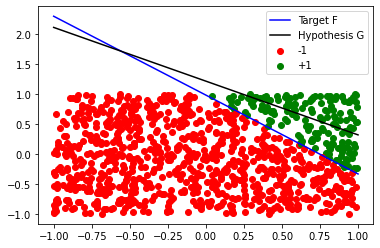

In [ ]:
# Gráfico ultima rodada de E_out da questão b)
p.plot_f_g()

In [ ]:
# questão c)
lr = Linear_Regression_experiment()
lr.number_of_points = 100
lr.initialize_points()
lr.linear_regression_algorithm()
w = lr.w_history[-1]
p = PLA_experiment()
p.run_experiment(number_of_points=100, noise=True, i_steps=10 , w_initial=w)

Average steps:10.0 and average E_out:0.139014,  using 100 points.


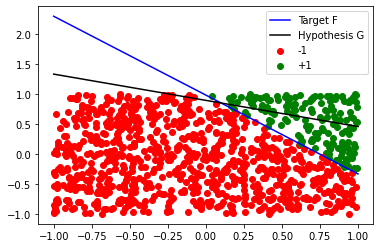

In [ ]:
# Gráfico ultima rodada de E_out da questão c)
p.plot_f_g()

In [ ]:
# questão d)
lr = Linear_Regression_experiment()
lr.number_of_points = 100
lr.initialize_points()
lr.linear_regression_algorithm()
w = lr.w_history[-1]
p = PLA_experiment()
p.run_experiment(number_of_points=100, noise=True, i_steps=50 , w_initial=w)

Average steps:50.0 and average E_out:0.12839499999999998,  using 100 points.


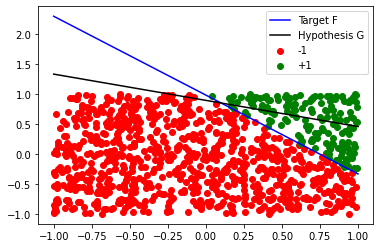

In [ ]:
# Gráfico ultima rodada de E_out da questão d)
p.plot_f_g()

In [ ]:
# Resolvendo o décimo exercício da lista de Inteligência Computacional
lr = Linear_Regression_experiment()
lr.run_experiment(number_of_points=1000, noise=True, random_f=False)

Average E_in:0.505005 and average E_out:0.509887,  using 1000 points.


- Answer 8th question : [d] $\approx 0.5 $ avg. $E_{in}$

In [ ]:
# Resolvendo o décimo segundo exercício da lista de Inteligência Computacional
lr = Linear_Regression_experiment()
lr.run_experiment(number_of_points=1000, noise=True, random_f=False, linear=False)

Average E_in:0.123864 and average E_out:0.125052,  using 1000 points.


In [ ]:
# Resolvendo o décimo primeiro exercício da lista de Inteligência Computacional
print(f"W vector: {lr.w_history[-1]}")
lr.check_function()

W vector: [-1.04268599 -0.02922132 -0.00650775 -0.15289837  1.53120767  1.63918902]
The function which is similar to our founded g is G_a


- Answer 9th question : [a] $\approx g(x_1,x_2) = sign(-1 - 0.05x_1 + 0.08x_2 + 0.13x_1x_2 + 1.5x_1^2 + 1.5x_2^2 ) $ 
- Answer 10th question : [b] $\approx 0.1 $ avg. $E_{out}$